In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [9]:
df = yf.download(['AAPL', 'GOOG', 'META'], start="2013-04-01", end="2023-04-01")
df = np.log(1+ df['Adj Close'].pct_change()).dropna()
#We use the log to have "fairness" between stocks if there are price magnitude dicrepencies

[*********************100%***********************]  3 of 3 completed


The goal of Modern Portfolio Theory is to find the optimal weight to allocate to each stock in order to maximise the return of the portfolio and minimise its variance. The problem can be written as followed :

$$ \underset{w}{\text{min}} \, \, w^T \Sigma w \, \, \\ \text{ s.t. } w^T1 = 1 \text{ and } w\geq0 $$

Return vs volatility chart

In [10]:
#Monte Carlo approach :
#We simulate n portfolios with as many different combinations of weights as possible.

n_portfolios = 10_000
n_stocks = df.shape[1]
weight = np.zeros((n_portfolios, n_stocks))
exp_return, exp_vol, sharpe_ratio = np.zeros(n_portfolios), \
                                    np.zeros(n_portfolios), \
                                    np.zeros(n_portfolios)

mean_return = df.mean()
sigma = df.cov()
for i in range(n_portfolios):
    #generate a weight vector
    w = np.array(np.random.random(n_stocks))
    w = w / np.sum(w)
    weight[i, :] = w

    #compute the return and volatility associated
    exp_return[i] = np.sum(mean_return*w)
    exp_vol[i] = np.sqrt(w.T@(sigma@w))

    #compute SR
    sharpe_ratio[i] = exp_return[i]/exp_vol[i]

In [11]:
imax_portfolio = sharpe_ratio.argmax() 
weight[imax_portfolio]

array([0.82518221, 0.08783333, 0.08698446])

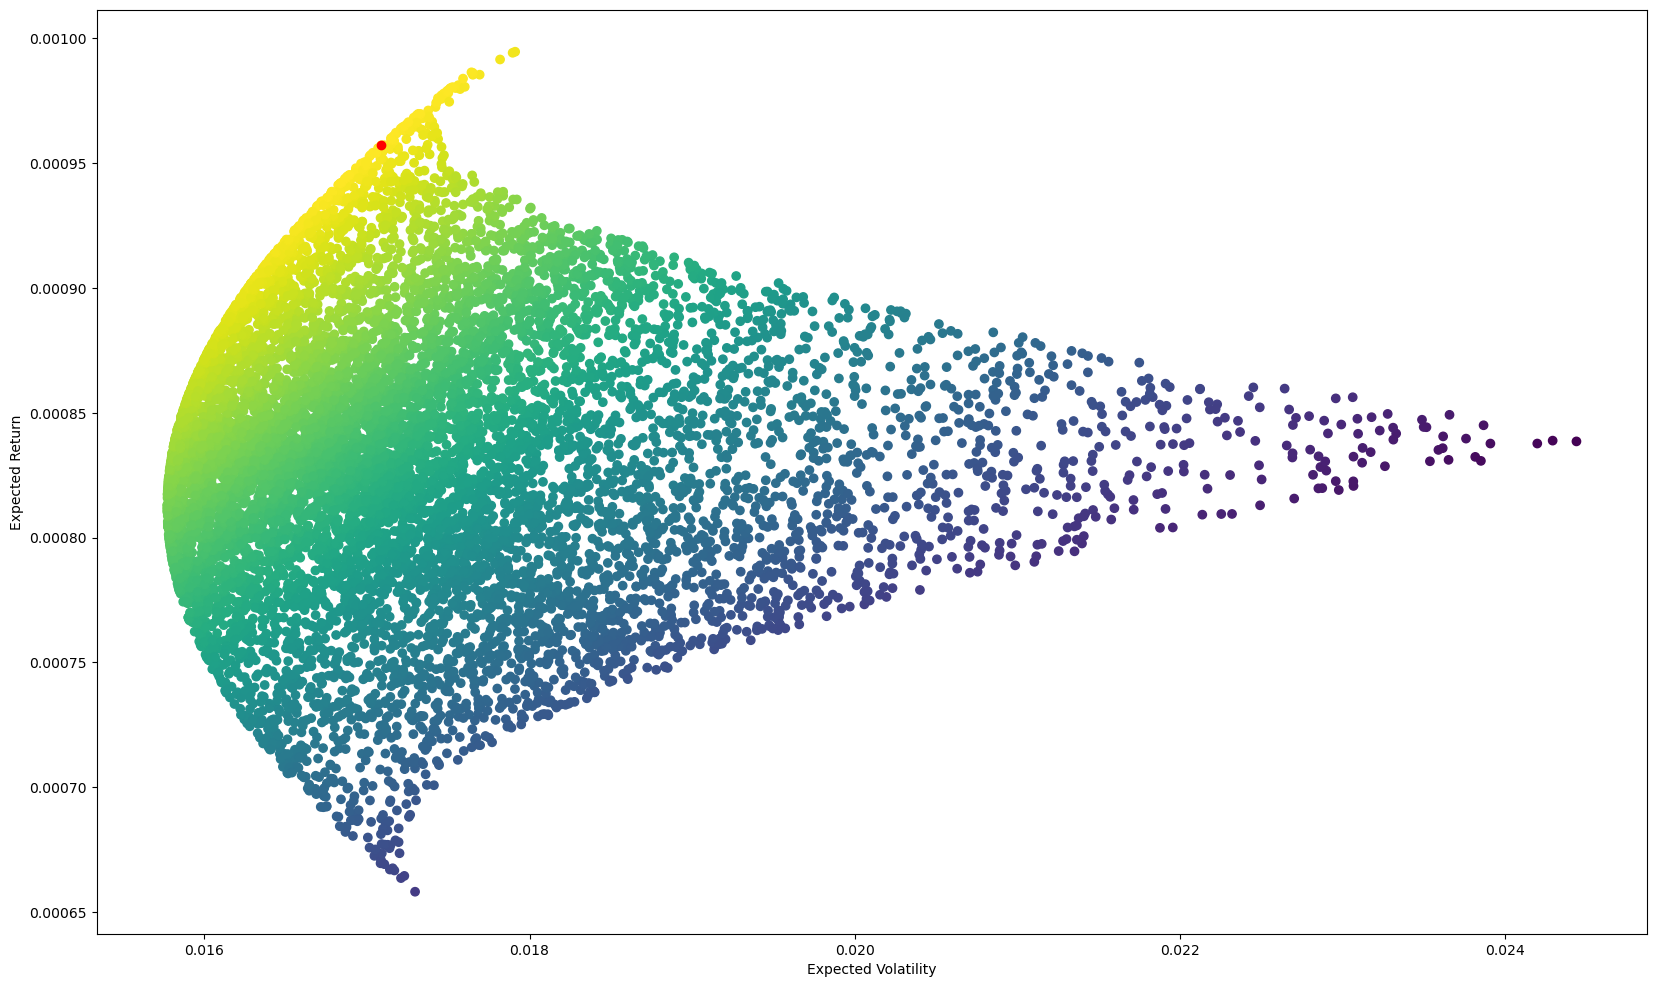

In [28]:
plt.figure(figsize=(20,12))
plt.scatter(exp_vol, exp_return, c=sharpe_ratio)
plt.scatter(exp_vol[imax_portfolio], exp_return[imax_portfolio], c='r')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.show()

Plot the Efficient Frontier :
How to do it ? For each return, we have to find the best volatility.

In [25]:
returns_list = np.linspace(0.00065, 0.001, 1000)
vol_best = []

def vol(w): 
    return np.sqrt(w.T@(sigma@w))

def check_sum_one(w):
    return np.sum(w) - 1

def get_return(w):
    return np.sum(mean_return*w)

w0 = [1/n_stocks]*n_stocks
bounds = tuple([(0,1)]*n_stocks)
for ret in returns_list : 
    constraints = ({'type':'eq', 'fun':check_sum_one},\
                   {'type':'eq', 'fun': lambda w: get_return(w) - ret})
    opt_vol = minimize(vol, w0, method='SLSQP', \
                       bounds=bounds, constraints=constraints)
    vol_best.append(opt_vol['fun'])

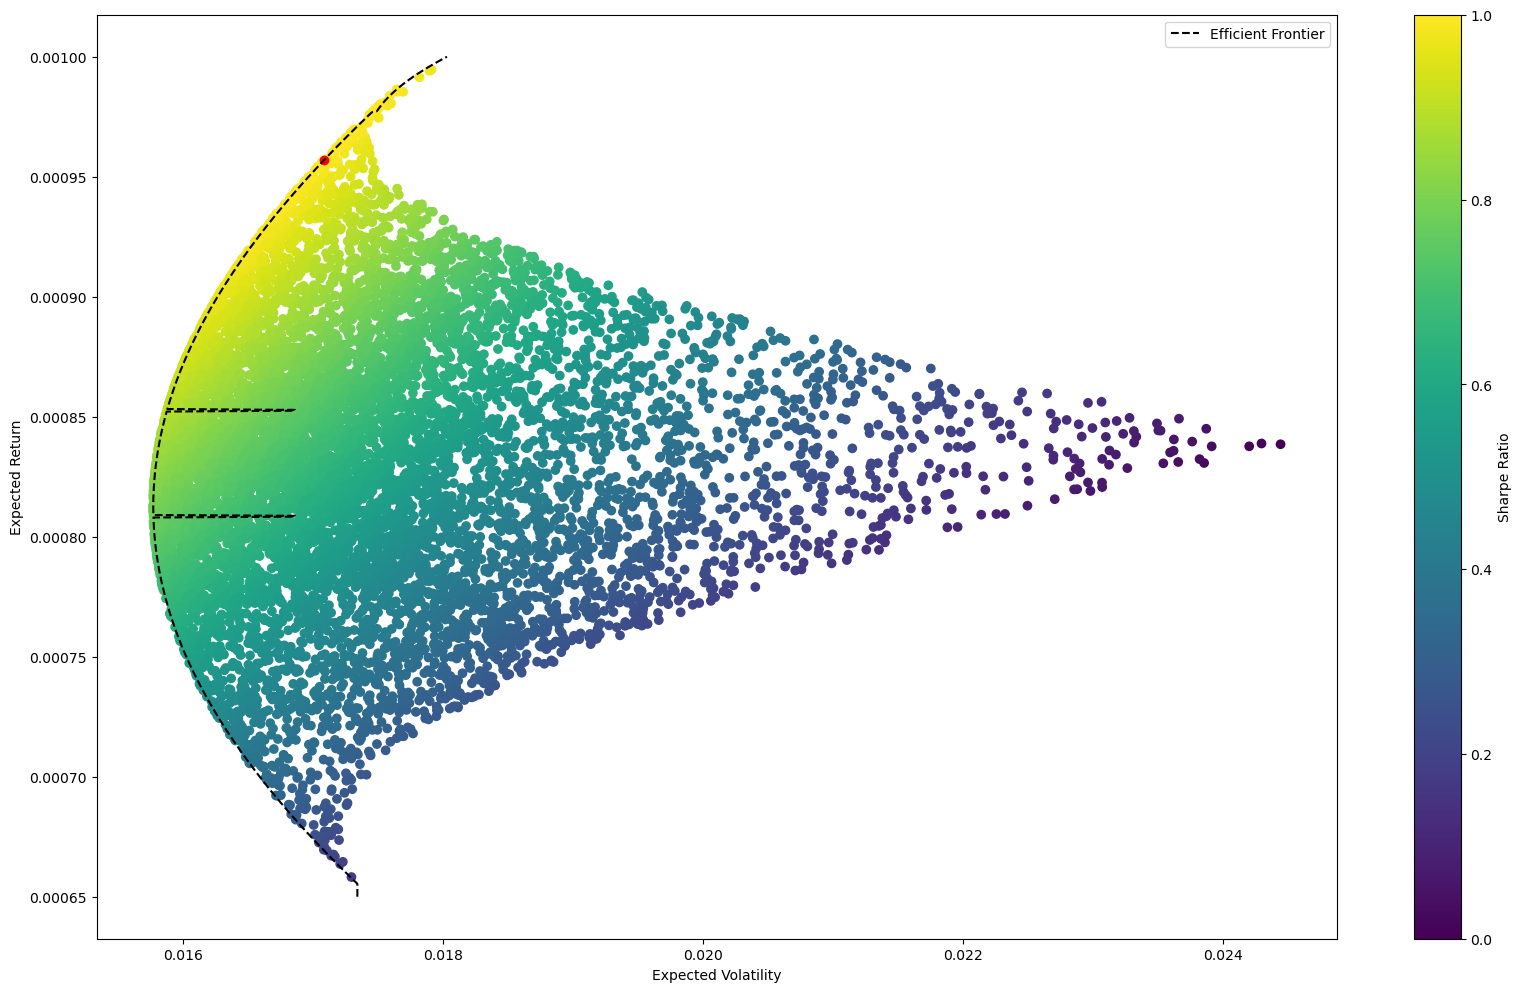

In [27]:
plt.figure(figsize=(20,12))
plt.scatter(exp_vol, exp_return, c=sharpe_ratio)
plt.scatter(exp_vol[imax_portfolio], exp_return[imax_portfolio], c='r')
plt.colorbar(label='Sharpe Ratio')
plt.plot(vol_best, returns_list, '--', c='k', label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.show()